# CEE 598: Uncertainty Quantification
## Assignment Six
### Noah Garfinkle (garfink2@illinois edu)
### 03 May 2020

## Imports and Set Up

In [182]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pytest
import chaospy as cp
import pandas as pd
from scipy.integrate import odeint

## References

In [6]:
# https://chaospy.readthedocs.io/en/master/tutorial.html
# https://chaospy.readthedocs.io/en/master/_modules/chaospy/quadrature/clenshaw_curtis.html
# https://chaospy.readthedocs.io/en/master/quadrature.html#module-chaospy.quadrature.clenshaw_curtis
# https://chaospy.readthedocs.io/en/master/quadrature.html#module-chaospy.quadrature.sparse_grid
# https://chaospy.readthedocs.io/en/master/recipes/galerkin.html

## General Approach

Building off of assignment five, I have opted to again utilize the third path of confirming an existing library.  As with Assignment Five, I have opted to utilize Chaospy for Python.

In order to evaluate the integral, I have opted to utilize an approach similar to Monte Carlo approximations of the integral, represented by

$$\int{f(X)} \approx \sum_{n=1}^{N}W_nf(X_n)$$

Where $N$ is the number of samples, $X_n$ is each individual sample, $f(X_n)$ is the evaluation of the target function at the sample coordinates, and $W_n$ is the weight of the sample as defined by the rule utilized.

## Problem 1.
Consider the following target function

$$f(x)=f(x_1,x_2,...,x_5)=\prod_{i=1}^5sin(ix_i)$$

where $x_i \in [0,1],\forall_i$.  We would like to approximate $\int_{[0,1]^5}f(x)dx$ using quadrature.  Compare the following multidimensional quadrature rules:

I have assumed that $x_i$ are each uniformally distributed.

In [47]:
def func(x):
    x1,x2,x3,x4,x5 = x
    value = np.sin(x1) * np.sin(2*x2) * np.sin(3*x3) * np.sin(4*x4) * np.sin(5*x5)
    return value

In [48]:
distribution_x = cp.J(cp.Uniform(0,1),cp.Uniform(0,1),cp.Uniform(0,1),cp.Uniform(0,1),cp.Uniform(0,1))

In [115]:
def calculateIntegral(order,sampleRule="clenshaw_curtis",sparse=False,growth=False):
    abscissas, weights = cp.generate_quadrature(order, distribution_x, rule=sampleRule,sparse=sparse,growth=growth)
    samples = abscissas.T
    integral = 0.0
    for i,sample in enumerate(samples):
        weight = weights[i]
        integral += weight * func(sample)
    return integral

In [140]:
def evaluateIntegralAtMultipleLevels(sampleRule="clenshaw_curtis",sparse=False,growth=False,levels=[1,2,3]):
    orders = []
    integrals = []
    rules = []
    sparses = []
    for order in levels:
        orders.append(order)
        integrals.append(calculateIntegral(order,sampleRule=sampleRule,sparse=sparse,growth=growth))
        rules.append(sampleRule)
        sparses.append(sparse)
    df = pd.DataFrame({"Order":orders,"Integral":integrals,"Rule":rules,"Sparse":sparses})
    return df

### Problem 1a. Tensor product using Clenshaw-Curtis (CC) points at levels 1,2, and 3.

Note: Clenshaw-Curtis points and their weights are given on Slide 15 of Lecture 20

Text(0.5, 1.0, 'Problem 1a. Cleanshaw-Curtis')

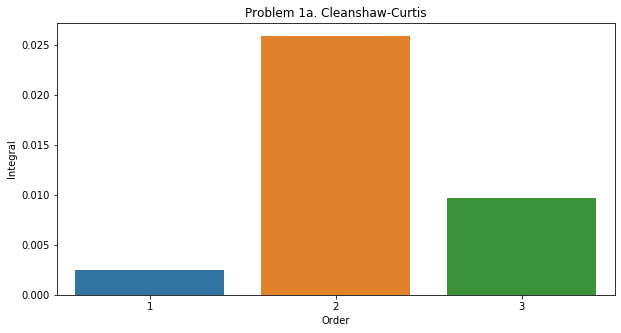

In [195]:
df_1a = evaluateIntegralAtMultipleLevels()
fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Order",y="Integral",data=df_1a,ax=ax)
ax.set_title("Problem 1a. Cleanshaw-Curtis")

### Problem 1b. Sparse grid using CC points at levels 1, 2, and 3.

Text(0.5, 1.0, 'Problem 1b. Cleanshaw-Curtis with Sparse Grid')

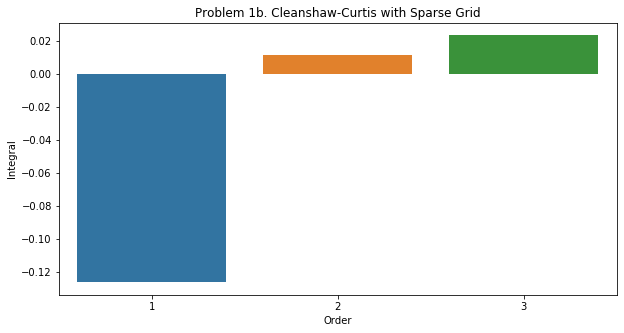

In [196]:
df_1b = evaluateIntegralAtMultipleLevels(sparse=True,growth=True)
fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Order",y="Integral",data=df_1b,ax=ax)
ax.set_title("Problem 1b. Cleanshaw-Curtis with Sparse Grid")

### Problem 1c. Sparse grid using Gauss-Legendre quadrature points at sparse grid levels 1,2,3, and 4.  Note that the level for one dimensional GL quadrature, compared to 1D CC quadrature, involves different numbers of points.  For example, level-2 CC has 3 points, but level-2 GL has 2 points.  So, it is expected that at the same sparse grid level, the number of multidimensional points are not the same between CC and GL.

Text(0.5, 1.0, 'Problem 1c. Gauss-Legendre')

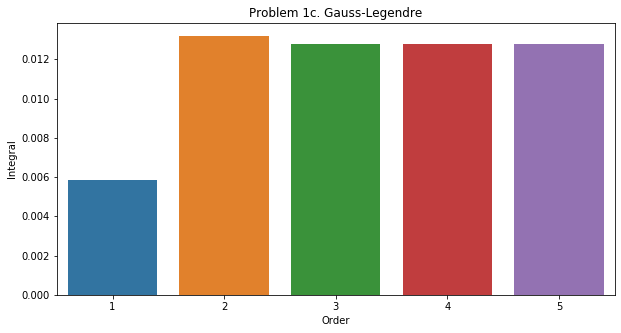

In [197]:
df_1c = evaluateIntegralAtMultipleLevels(sampleRule="gauss_legendre",sparse=False,growth=False,levels=[1,2,3,4,5])
fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Order",y="Integral",data=df_1c,ax=ax)
ax.set_title("Problem 1c. Gauss-Legendre")

Text(0.5, 1.0, 'Problem 1c. Gauss-Legendre with Sparse Grid')

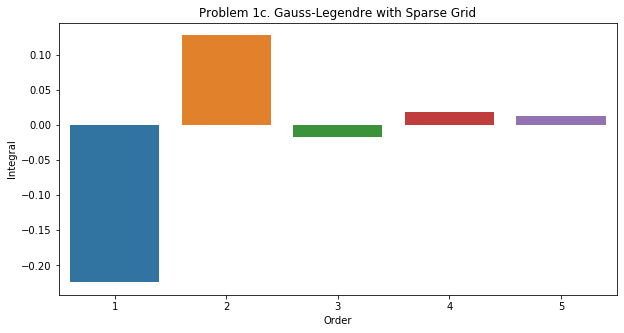

In [198]:
df_1c2 = evaluateIntegralAtMultipleLevels(sampleRule="gauss_legendre",sparse=True,growth=True,levels=[1,2,3,4,5])
fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Order",y="Integral",data=df_1c2,ax=ax)
ax.set_title("Problem 1c. Gauss-Legendre with Sparse Grid")

In [199]:
df_stacked = pd.concat([df_1a,df_1b,df_1c,df_1c2])
metaRule = []
for i,row in df_stacked.iterrows():
    sparse = ""
    if row["Sparse"] == True:
        sparse = "Sparse Grid"
    rule = f"{row['Rule']} {sparse}"
    metaRule.append(rule)
df_stacked["Meta Rule"] = metaRule

In [200]:
# Run a high order problem to try to fit a better estimate
bestGuessIntegral = calculateIntegral(10,sampleRule="clenshaw_curtis",sparse=False,growth=False)
print(bestGuessIntegral)

0.012788234790550164


Text(0.5, 1.0, 'Comparison of Solution Approaches')

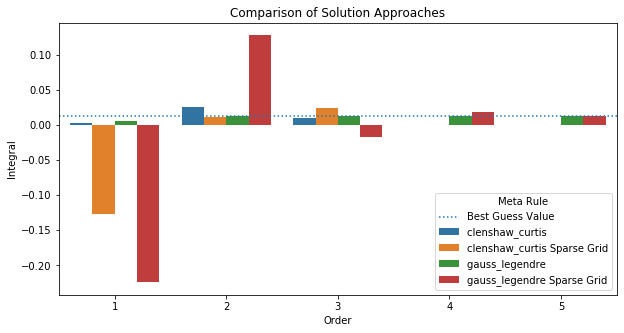

In [201]:
fig,ax = plt.subplots(figsize=(10,5))
ax.axhline(bestGuessIntegral,ls=":",label="Best Guess Value")
sns.barplot(x="Order",y="Integral",hue="Meta Rule",data=df_stacked,ax=ax)
ax.set_title("Comparison of Solution Approaches")

In spite of my expectations, sparse grids as implemented do not improve my solution until allowing a greater order, suggesting that I have not implemented them correctly.

The Gauss-Legendre rule appears to perform best, which I believe is reasonable as it is known to be a good solution approach for uniform distributions as we have with this problem, while the Clenshaw-Curtis rule is more general but often faster.

## Problem 2.
Using the Stochastic Galerkin approach, find a PCE approximation for $y$ given by

$$ay=bc+d$$

where $a=3-0.4\Psi_2(z), b=-5+0.4\Psi_1(z), c=3+0.02\Psi_1(z), and d=11-3\Psi_1(z)$ are four random parameters, where ${z}$ is a uniform random variable in $[0,1]$ and ${\Psi_i}$ are Legendre polynomials.

In [181]:
distribution_z = cp.J(cp.Uniform(0,1),cp.Uniform(0,1),cp.Uniform(0,1),cp.Uniform(0,1))